# LightGBM. Importancia de variables, Calibración y Curvas de Aprendizaje

In [9]:
# Configuración
from pathlib import Path
DATA_PATH  = Path("../data/processed/ddos_findef.csv")
TARGET_COL = "y"
DROP_COLS  = []
RANDOM_STATE = 42
print("Datos:", DATA_PATH, "| Target:", TARGET_COL)

Datos: ../data/processed/ddos_findef.csv | Target: y



## 1) Carga y preprocesamiento


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier

df = pd.read_csv(DATA_PATH)
if TARGET_COL not in df.columns:
    raise ValueError(f"No encuentro '{TARGET_COL}'.")

if DROP_COLS:
    df = df.drop(columns=[c for c in DROP_COLS if c in df.columns])

y = df[TARGET_COL].astype(int)
X = df.drop(columns=[TARGET_COL])

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]
print("num:", len(num_cols), "cat:", len(cat_cols))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                     ("scaler", StandardScaler(with_mean=False))])
cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                     ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))])  # Cambio aquí

preprocess = ColumnTransformer([("num", num_pipe, num_cols),
                                ("cat", cat_pipe, cat_cols)])

base_clf = LGBMClassifier(
    n_estimators=600, learning_rate=0.05, num_leaves=64,
    subsample=0.8, colsample_bytree=0.8, class_weight="balanced",
    random_state=RANDOM_STATE, n_jobs=-1
)

pipe = Pipeline([("prep", preprocess), ("clf", base_clf)])
pipe

num: 19 cat: 0


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True



## 2) Entrenamiento y métricas


[LightGBM] [Info] Number of positive: 444373, number of negative: 1683928
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4483
[LightGBM] [Info] Number of data points in the train set: 2128301, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


ROC AUC: 0.9999534473317099
PR  AUC: 0.9995821628541421

               precision    recall  f1-score   support

           0     0.9999    0.9987    0.9993    420983
           1     0.9950    0.9996    0.9973    111093

    accuracy                         0.9989    532076
   macro avg     0.9975    0.9991    0.9983    532076
weighted avg     0.9989    0.9989    0.9989    532076



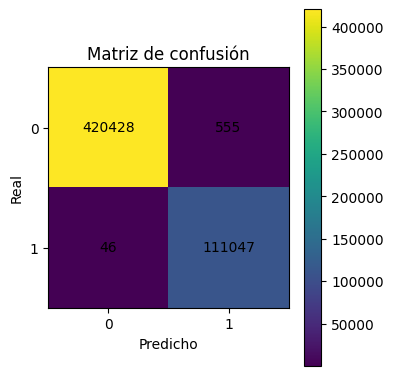

In [11]:

from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

pipe.fit(X_train, y_train)
proba_test = pipe.predict_proba(X_test)[:,1]
pred_test = (proba_test >= 0.5).astype(int)

print("ROC AUC:", roc_auc_score(y_test, proba_test))
print("PR  AUC:", average_precision_score(y_test, proba_test))
print("\n", classification_report(y_test, pred_test, digits=4))

cm = confusion_matrix(y_test, pred_test)
fig = plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Matriz de confusión")
plt.colorbar()
plt.xticks([0,1],[0,1]); plt.yticks([0,1],[0,1])
plt.xlabel("Predicho"); plt.ylabel("Real")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j,i,cm[i,j],ha="center",va="center")
plt.tight_layout(); plt.show()



## 3) Importancia de variables (modelo + Permutation Importance)


Top 30 por Importancia del Modelo (LGBM):


,feature,importance
13,Init_Win_bytes_forward,6597
12,Flow Packets/s,5332
0,Flow Duration,5262
14,Init_Win_bytes_backward,3927
11,Flow Bytes/s,2725
1,Total Fwd Packets,1666
2,Total Backward Packets,1367
4,Total Length of Bwd Packets,1344
3,Total Length of Fwd Packets,1293
8,Bwd Packet Length Max,1103



Calculando Permutation Importance (test)...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/


Top 30 por Permutation Importance (test):


,feature,importance_mean,importance_std
13,Init_Win_bytes_forward,0.074254,0.000184
8,Bwd Packet Length Max,0.061071,0.000283
9,Bwd Packet Length Min,0.039052,0.000360
16,min_seg_size_forward,0.038884,0.000201
5,Fwd Packet Length Max,0.026547,0.000126
14,Init_Win_bytes_backward,0.024049,0.000212
3,Total Length of Fwd Packets,0.022244,0.000081
2,Total Backward Packets,0.021120,0.000118
10,Bwd Packet Length Mean,0.019391,0.000155
1,Total Fwd Packets,0.008585,0.000075


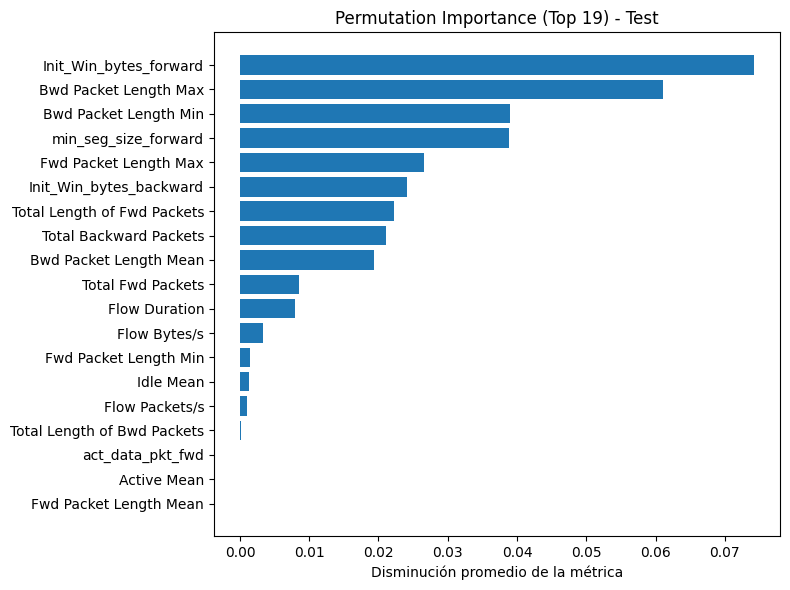

In [13]:
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# 1. Acceder al preprocesador YA AJUSTADO desde el 'pipe'
fitted_preprocess = pipe.named_steps['prep']

# 2. Definir la función para obtener los nombres de características
def get_feature_names(preprocess_transformer, numerical_cols, categorical_cols):
    
    # Iniciar cat_names como lista vacía
    cat_names = [] 
    
    if categorical_cols: 
        oh_encoder = preprocess_transformer.named_transformers_['cat'].named_steps['onehot']
        cat_names = oh_encoder.get_feature_names_out(categorical_cols) 
    
    num_names = numerical_cols
    
    # Retornar la concatenación de ambos
    return np.concatenate([num_names, cat_names])

# 3. Obtener los nombres
feature_names = get_feature_names(fitted_preprocess, num_cols, cat_cols)

# 4. Importancia del modelo (LGBM)
model = pipe.named_steps["clf"]
fi = pd.DataFrame({"feature": feature_names, "importance": model.feature_importances_})
print("Top 30 por Importancia del Modelo (LGBM):")
display(fi.sort_values(by="importance", ascending=False).head(30))

# 5. Permutation Importance (test)
print("\nCalculando Permutation Importance (test)...")
perm = permutation_importance(pipe, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_df = pd.DataFrame({
    "feature": feature_names,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
})

print("\nTop 30 por Permutation Importance (test):")
display(perm_df.sort_values(by="importance_mean", ascending=False).head(30))

# 6. Gráfico de Permutation Importance
TOP_N = 20
n_to_show = min(TOP_N, len(perm_df)) 

perm_df_sorted = perm_df.sort_values(by="importance_mean", ascending=True).tail(n_to_show)

fig = plt.figure(figsize=(8, max(4, int(n_to_show * 0.35))))
plt.barh(
    perm_df_sorted["feature"],
    perm_df_sorted["importance_mean"]
)
plt.title(f"Permutation Importance (Top {n_to_show}) - Test")
plt.xlabel("Disminución promedio de la métrica")
plt.tight_layout()
plt.show()

In [ ]:
# SHAP
try:
    import shap, matplotlib.pyplot as plt
    explainer = shap.TreeExplainer(model)
    X_test_t = preprocess.transform(X_test)
    X_test_sample = shap.sample(X_test_t, 5000) 
    
    # Calcular SHAP values SOLO en la muestra
    print(f"Calculando SHAP values en una muestra de {len(X_test_sample)} filas...")
    shap_values = explainer.shap_values(X_test_sample)
    
    # Usar la muestra (X_test_sample) para el plot
    print("Creando gráfico...")
    shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, show=False)
    
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("SHAP no disponible:", e)


## 4) Calibración (Brier, ECE, curvas de confiabilidad)


In [ ]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

def expected_calibration_error(y_true, y_prob, n_bins=15):
    y_true = np.asarray(y_true); y_prob = np.asarray(y_prob)
    bins = np.linspace(0,1,n_bins+1); ece=0.0; total=len(y_true)
    for i in range(n_bins):
        l,r=bins[i],bins[i+1]
        mask=(y_prob>=l)&(y_prob<(r if i<n_bins-1 else r))
        if np.any(mask):
            acc=y_true[mask].mean(); conf=y_prob[mask].mean()
            ece += abs(acc-conf)*(mask.sum()/total)
    return ece

def plot_reliability(y_true, proba_dict, n_bins=15, title_suffix=""):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(5,5))
    plt.plot([0,1],[0,1],"--")
    for name,p in proba_dict.items():
        frac_pos, mean_pred = calibration_curve(y_true, p, n_bins=n_bins, strategy="uniform")
        plt.plot(mean_pred, frac_pos, marker="o", label=name)
    plt.xlabel("Probabilidad promedio por bin"); plt.ylabel("Fracción de positivos")
    plt.title(f"Curva de confiabilidad {title_suffix}"); plt.legend(); plt.tight_layout(); plt.show()

orig_brier = brier_score_loss(y_test, proba_test)
orig_ece   = expected_calibration_error(y_test.values, proba_test, n_bins=15)
print(f"Brier (original): {orig_brier:.6f} | ECE (original): {orig_ece:.6f}")

cal_iso = CalibratedClassifierCV(pipe, method="isotonic", cv=5).fit(X_train, y_train)
cal_sig = CalibratedClassifierCV(pipe, method="sigmoid",  cv=5).fit(X_train, y_train)

proba_iso = cal_iso.predict_proba(X_test)[:,1]
proba_sig = cal_sig.predict_proba(X_test)[:,1]

iso_brier = brier_score_loss(y_test, proba_iso); iso_ece = expected_calibration_error(y_test.values, proba_iso, 15)
sig_brier = brier_score_loss(y_test, proba_sig); sig_ece = expected_calibration_error(y_test.values, proba_sig, 15)
print(f"Brier (isotonic): {iso_brier:.6f} | ECE (isotonic): {iso_ece:.6f}")
print(f"Brier (sigmoid):  {sig_brier:.6f} | ECE (sigmoid):  {sig_ece:.6f}")

plot_reliability(y_test.values, {"Original": proba_test, "Isotonic": proba_iso, "Sigmoid": proba_sig}, 15, "— LightGBM")


## 5) Curvas de aprendizaje


In [ ]:
from sklearn.model_selection import learning_curve, StratifiedKFold
import matplotlib.pyplot as plt

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
train_sizes, train_scores, val_scores = learning_curve(
    pipe, X, y, cv=cv, scoring="roc_auc", n_jobs=-1,
    train_sizes=np.linspace(0.1,1.0,6), shuffle=True
)
train_mean, val_mean = train_scores.mean(axis=1), val_scores.mean(axis=1)
train_std,  val_std  = train_scores.std(axis=1),  val_scores.std(axis=1)

fig = plt.figure(figsize=(6,4))
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean-val_std,     val_mean+val_std,     alpha=0.2)
plt.plot(train_sizes, train_mean, marker="o", label="Entrenamiento (AUC)")
plt.plot(train_sizes, val_mean,   marker="o", label="Validación (AUC)")
plt.xlabel("Tamaño de entrenamiento"); plt.ylabel("ROC AUC"); plt.title("Curvas de aprendizaje — LightGBM")
plt.legend(); plt.tight_layout(); plt.show()